Available Encoders 

DCAE - Causing Python and Pytorch Dependency issues

DGAE (Diffusion Guided Auto Encoder)

FASTMAE

MAETok

EfficientSAM

EQ-VAE

PaGoDA (Progressive Growing of Diffusion Autoencoder)

or
Most top avaialble research papers efficient T2I uses VQGAN/VQVAE . 



In [1]:
from PIL import Image
import torch
from diffusers import AutoencoderKL
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from diffusers import AutoencoderDC

In [2]:
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", subfolder="vae")
vae.parameters

<bound method Module.parameters of AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps

torch.Size([1, 3, 256, 256])

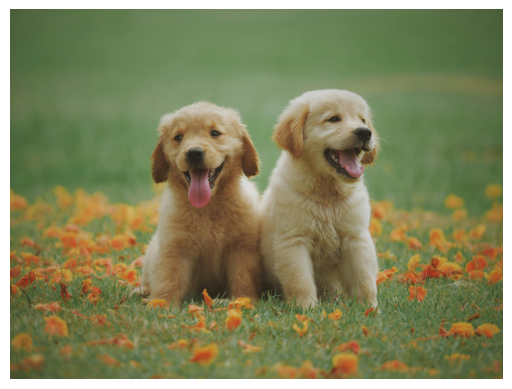

In [2]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),                 
    transforms.Normalize([0.5]*3, [0.5]*3)])

image = Image.open("Images/testImage.jpg").convert("RGB")
image_tensor = preprocess(image).unsqueeze(0)
plt.imshow(image)
plt.axis('off')
image_tensor.shape


In [4]:
with torch.no_grad():
    latent_dist = vae.encode(image_tensor).latent_dist
    encoded = latent_dist.sample() * vae.config.scaling_factor
encoded.shape

torch.Size([1, 16, 32, 32])

In [5]:
with torch.no_grad():
    latents = encoded / vae.config.scaling_factor
    decoded = vae.decode(latents).sample
decoded.shape

torch.Size([1, 3, 256, 256])

torch.Size([1, 3, 256, 256])

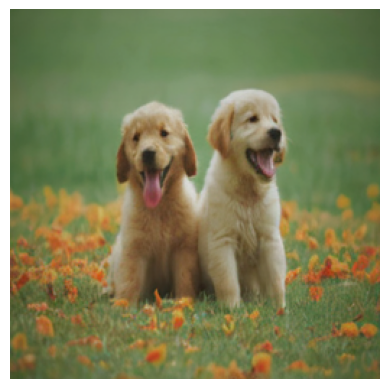

In [6]:
decoded = (decoded / 2 + 0.5).clamp(0, 1)
decoded_image = transforms.ToPILImage()(decoded.squeeze(0))
plt.imshow(decoded_image)
plt.axis('off')
image_tensor.shape

After Talking to Authors of Paper DCAE, I am able to resolve the issue of DCAE

(the below code will run smoothly in CUDA Env)

cpu
Latent Shape: torch.Size([1, 128, 4, 4])
Decoded Shape: torch.Size([1, 3, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

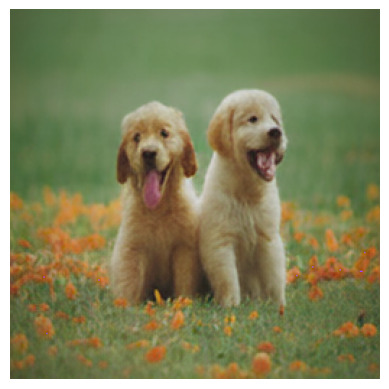

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dc_ae: AutoencoderDC = AutoencoderDC.from_pretrained(f"mit-han-lab/dc-ae-f64c128-in-1.0-diffusers", torch_dtype=torch.float32).to(device).eval()


x = image_tensor.to(device)
latent = dc_ae.encode(x).latent
print(f"Latent Shape: {latent.shape}")
y = dc_ae.decode(latent).sample
print(f"Decoded Shape: {y.shape}")
decodedImg = y * 0.5 + 0.5
decoded_image = transforms.ToPILImage()(decodedImg.squeeze(0))
plt.imshow(decoded_image)
plt.axis('off')